# Ranking feature importance based on class membership feature weights

In order to get more insight into how our classifiers are making a decision, and display this insight in our webapp, we wish to gather an idea of feature classification importance. The inspiration for this came from this image:
![Representation of feature weights](https://blog.openai.com/content/images/2017/04/sentiment-prediction.png)

<sup>(you can find the full animation in OpenAI's Sentiment Neuron research paper [here](https://blog.openai.com/unsupervised-sentiment-neuron/) )</sup>

To demonstrate how this is done, we use the LinearSVM classifer that was shown to be the best performer in the cross-comparison notebook. We extract the coefficients after training the classifier, match vocabularly indices to coefficients, and return them in tuples. Let's begin the process below, by importing the libraries we need.

For notebook brevity, I've employed some of the training_helper functions I wrote. I will give a brief explanation of each fuction used.

In [1]:
import sys
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
sys.path.append('../')
from scripts.training_helpers import get_data_frame, fit_model

Now let's set up the data, create our classifier pipeline and fit it to our data.

In [2]:
data_fm = get_data_frame()

X = data_fm['review']
y = np.asarray(data_fm['deceptive'],dtype=int)

cv = CountVectorizer(stop_words='english', ngram_range=(0, 2))
tfidf = TfidfTransformer()
classifier = LinearSVC(random_state=0) # Starting seed
model = Pipeline([ ('cv', cv), ('tfidf', tfidf), ('classifier', classifier) ])

fit_model(model, X, y)

All pretty straightforward so far, Keep in mind, this model is fitted to ALL of our data, for feature weight extraction.

Let's see how well our model does in 5-fold cross validation. I will import the helper function, get_accuracy, which simply runs our model and dataset through this process and returns us the average accuracies of the folds.

In [3]:
from scripts.training_helpers import get_accuracy
get_accuracy(model, X, y, 5)

0.8681249999999998

Seeems to agree with the figures produced in our cross-classifier comparison notebook. 
Now, I'll import a helper function that extracts the coefficients from the classifier, the feature names from the vocabulary, and plots the coefficient values of the top 20 Deceptive and Genuine words respectively.

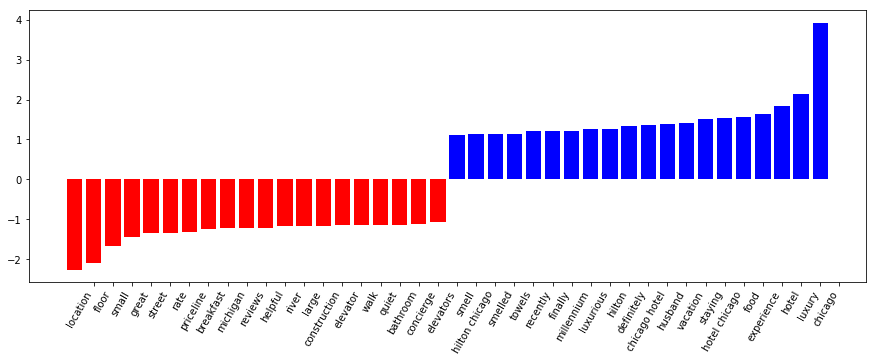

In [4]:
from scripts.training_helpers import plot_coefficients
plot_coefficients(model, 20)

Sweet. We can see from this that the most important words to classify the negative class, 'Genuine', are
- 'location', 'floor', 'small', 'great', etc, 
and the ones that contribute most to a 'Deceptive' classification are 
- 'chicago', 'luxury', 'hotel', 'experience', etc.

This is conclusive with evidence and findings in other research papers in the opinion-spam detection domain. Deceptive ones are usually quite general, using words from the product or service description. (Eg., it seems less likely that a genuine review would mention 'Chigago' in the review, as other people can clearly see that the hotel is in Chicago if they're reading the review in the first place).

Now let's take some reviews from Yelp, get the classification, feature weights and confidence score.
I'll import three functions to help with this.

In [45]:
from scripts.training_helpers import get_classification
from scripts.training_helpers import get_feature_weights
from scripts.training_helpers import get_confidence

They do as you would imagine: The first gets the Genuine or Deceptive classification, the second gets the word feature weights we just demonstratedm and the third gets the confidence of the decision we make.

First, let's try a genuine-looking positive review from Yelp. I'll choose one at random.
The review is from Brennans Bread, famous Irish bread bakery based in Dublin. The review is the top review, from a 'trusted reviewer' who has left a bunch of genuine-seeming reviews on places in Dublin.

In [46]:
genuine_positive = """
"Old Mr Brennan" is as Dublin as a one-and-one from a Roma chipper. He talks in an old-style Dublin accent, loves a good sliced pan and is likely to roar at you from the window of his truck. 

Although the original Mr Brennan is now long dead, he lives on as a highly effective marketing construct and his bread is an essential component of everything from children's lunchbox sandwiches to hungover bacon butties. 

Although he has tried to branch out into the healthier market with multi/wholegrain loaves, he will always be best known for that white 'plasticy' bread that you know you shouldn't love but really, really do.
"""

In [47]:
get_classification(model, genuine_positive)

'Genuine'

Off to a good start. Let's see the confidence it made this decision with:

In [48]:
get_confidence(model, genuine_positive)

-0.264872657624988

A confidence of 0.26 is relatively low. Let's take a deeper look at the feature weights for why it made this decision.

In [49]:
feature_weights = get_feature_weights(model, genuine_positive)
print(feature_weights)

{' Old': 0, 'Mr': 0.02360973593989185, 'Brennan ': 0, 'is': 0, 'as': 0, 'Dublin': -0.07595988055721259, 'a': 0, 'one and one': 0, 'from': 0, 'Roma': 0, 'chipper ': 0, 'He': 0, 'talks': 0, 'in': 0, 'an': 0, 'old style': -0.13705053341031628, 'accent ': 0, 'loves': -0.014490909246651626, 'good': -0.9981047851032214, 'sliced': 0, 'pan': -0.05656197735055141, 'and': 0, 'likely': 0.04865682482147587, 'to': 0, 'roar': 0.045221318314129295, 'at': 0, 'you': 0, 'the': 0, 'window': -0.5558568316623635, 'of': 0, 'his': 0, 'truck ': 0, 'Although': 0, 'original': -0.019619940128844878, 'Brennan': 0, 'now': 0, 'long': 0.3747906886794011, 'dead ': 0, 'he': 0, 'lives': 0.04059819592132023, 'on': 0, 'highly': 0.11770727608591038, 'effective': 0.10465893600614071, 'marketing': 0.05969799432626999, 'construct': 0, 'bread': -0.007231028079385074, 'essential': 0.06258195614562376, 'component': 0, 'everything': 0, 'children s': 0, 'lunchbox': 0, 'sandwiches': 0, 'hungover': 0, 'bacon': -0.10834389782974613,

Let's see the most 'Genuine' words from this review.

In [50]:
from scripts.training_helpers import get_importance
get_importance(feature_weights, 5)

[('good', -0.9981047851032214),
 ('window', -0.5558568316623635),
 ('tried', -0.27766813556640746),
 ('white', -0.258636720999571),
 ('love', -0.25460289170398626)]

Let's try a genuine-looking negative review.

In [51]:
genuine_negative = """
If you like paper thin walls, poor service & weak internet connection -- here's your hotel!

First of all, I could hear my neighbor SNORING next door. That's how thin. Don't expect an ounce of privacy.

There were issues that came up during my stay -- being woken up by phone calls (after asking them not to call me). I was awoken 3 times! "Hi, you have a do not disturb sign on your door." "YES BECAUSE I'M SLEEPING!" A brown haired woman at the front desk was lovely and professional but the manager here is a total amateur. After more issues she not only didn't offer me anything (like a free snack/ water/ wine / ANYTHING -- she didn't even apologize!) Couldn't believe it. 

The hotel is great location wise (but NO view) but I have such a bad taste in my mouth from the service. The waiter at breakfast couldn't FATHOM that I wanted to take my food to my room. Was a huge chore (and I felt like I was inconveniencing him) just to get a to-go box!

Also -- I'll never understand how in 2018 hotels don't have outlets near the bed to let you charge your phone. And again, spotty internet in 2018? Come on!

Bed is comfortable! Hotel is otherwise quiet. I just don't get what happened with my stay.
"""

In [52]:
get_classification(model, genuine_negative)

'Genuine'

Awesome. Let's see the confidence:

In [53]:
get_confidence(model, genuine_negative)

-0.44083062483279073

Pretty confident, almost twice the last. This is good, as it proves that sentiment doesn't have a massive say in the decision, which we were worried about.

And the feature weights:

In [54]:
get_importance(get_feature_weights(model, genuine_negative), 5)

[('location', -2.261541624614368),
 ('great', -1.4452797140537743),
 ('breakfast', -1.2457866769871966),
 ('bed', -0.9445275247592282),
 ('Bed', -0.9445275247592282)]

Now let's try this with a review that I'll write myself, randomly choosing a hotel with the intent of lowering it's rating.

In [55]:
deceptive_negative = """
I stayed in The Shelbourne Hotel for three nights while passing through Dublin. 
It's probably the worst place I've ever stayed. I had a very poor experience.
The staff were terribly rude, the service extremely poor, and the room smelled awful. 
I would not reccommend staying here at all.
"""

In [56]:
print(get_classification(model, deceptive_negative), get_confidence(model, deceptive_negative))

Deceptive 0.34690271277082674


A little higher than the first review we looked at. Not overly confident, but it got it right nonetheless.
Let's see the feature weights:

In [24]:
get_importance(get_feature_weights(model, deceptive_negative), 5)

[('nights', -1.0237306093682805),
 ('stayed', -0.3047104489853865),
 ('probably', -0.1306595022611684),
 ('passing', -0.08543167986250377),
 ('staff', -0.0027140078958273798)]

Now let's try a positive:

In [57]:
deceptive_positive = """
My stay in Brooks hotel was amazing to say the least. Every step of the way the staff were accomodating and friendly.
The room was comfortable and the service was excellent. Would highly reccommend any time you come to Dublin.
"""

In [58]:
print(get_classification(model, deceptive_positive), get_confidence(model, deceptive_positive))

Deceptive 0.17901650321911938


Not overly confident again, but correct. Let's look at the important features:

In [59]:
get_importance(get_feature_weights(model, deceptive_positive), 5)

[('comfortable', -0.24073586485046486),
 ('accomodating', -0.11206692524202412),
 ('staff', -0.0027140078958273798)]